#### Mnist Evaluation

In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/Colab Notebooks/autoencoders

%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1UMow24kXYpDLYgShcir7-CB3ZYQsgEih/Colab Notebooks/autoencoders


'/content/gdrive/.shortcut-targets-by-id/1UMow24kXYpDLYgShcir7-CB3ZYQsgEih/Colab Notebooks/autoencoders'

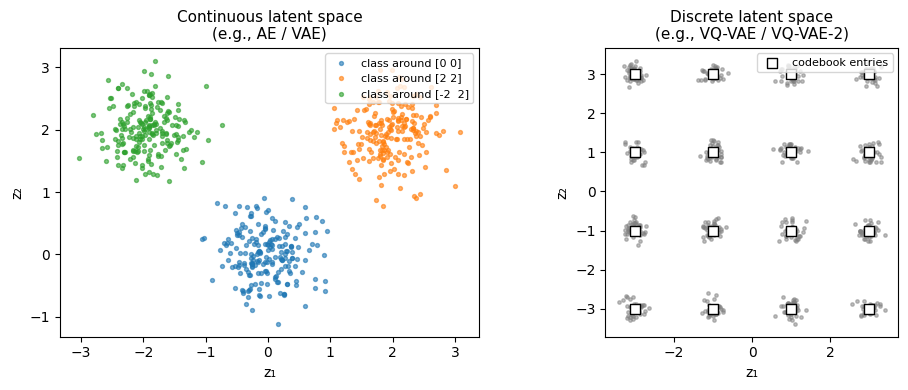

In [ ]:
# Continuous and Discrete Latent Representation
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: continuous latent
ax = axes[0]

# three Gaussian blobs (like 3 digit classes)
means = np.array([[0, 0], [2, 2], [-2, 2]])
colors = ["tab:blue", "tab:orange", "tab:green"]

for m, c in zip(means, colors):
    pts = np.random.randn(200, 2) * 0.4 + m
    ax.scatter(pts[:, 0], pts[:, 1], s=8, alpha=0.6, label=f"class around {m}")

ax.set_title("Continuous latent space\n(e.g., AE / VAE)", fontsize=11)
ax.set_xlabel("z₁")
ax.set_ylabel("z₂")
ax.legend(fontsize=8, loc="upper right")
ax.set_aspect("equal")

# Right: discrete latent
ax = axes[1]

# codebook: 4x4 grid
grid_x, grid_y = np.meshgrid(np.linspace(-3, 3, 4), np.linspace(-3, 3, 4))
codebook = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# sample around each codebook vector (like quantized latents)
for cx, cy in codebook:
    pts = np.random.randn(40, 2) * 0.15 + np.array([cx, cy])
    ax.scatter(pts[:, 0], pts[:, 1], s=6, alpha=0.5, color="gray")

# draw the codebook points themselves
ax.scatter(codebook[:, 0], codebook[:, 1],
           s=60, edgecolor="black", facecolor="white", marker="s", label="codebook entries")

ax.set_title("Discrete latent space\n(e.g., VQ-VAE / VQ-VAE-2)", fontsize=11)
ax.set_xlabel("z₁")
ax.set_ylabel("z₂")
ax.legend(fontsize=8, loc="upper right")
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [ ]:
# Encoded test pred.
import os
from pathlib import Path
import struct
import gzip

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# PATHS
# -----------------------------
mnist_root        = Path("./datasets/mnist")
mnist_train_dir   = mnist_root / "train"
mnist_test_dir    = mnist_root / "test"

output_mnist_root = Path("./best_models/output_mnist")
enc_save_root     = Path("./datasets/mnist/encoded_test_latent")
enc_save_root.mkdir(parents=True, exist_ok=True)

# Match your folder structure / filenames
mnist_model_cfgs = {
    "AuE": {
        "dir":   output_mnist_root / "output_mnist_ae",
        "ckpt":  "best_overall_AuE.pt",
    },
    "VAE": {
        "dir":   output_mnist_root / "output_mnist_vae",
        "ckpt":  "best_overall_VAE.pt",
    },
    "VQVAE": {
        "dir":   output_mnist_root / "output_mnist_vqvae",
        "ckpt":  "best_overall_VQVAE.pt",
    },
    "VQVA2": {
        "dir":   output_mnist_root / "output_mnist_vqvae2",
        "ckpt":  "best_overall_VQVA2.pt",
    },
}

# -----------------------------
# MNIST IDX LOADING
# -----------------------------
def _open_idx(path: Path):
    return gzip.open(path, "rb") if path.suffix == ".gz" else open(path, "rb")

def parse_idx_images(path: Path):
    with _open_idx(path) as f:
        header = f.read(16)
        if len(header) != 16:
            raise RuntimeError("Malformed IDX image header")
        magic, num, rows, cols = struct.unpack(">IIII", header)
        if magic != 2051:
            raise RuntimeError(f"Bad magic for images: {magic}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(num, rows, cols)

def find_idx_in_dir(dir_path: Path, candidates):
    # try direct names first
    for fn in candidates:
        p = dir_path / fn
        if p.exists():
            return p
    # scan recursively
    for p in dir_path.rglob("*"):
        if p.is_file() and p.name in candidates:
            return p
    return None

# Find test images
test_img_idx = find_idx_in_dir(
    mnist_test_dir,
    ["t10k-images.idx3-ubyte", "t10k-images-idx3-ubyte.gz"]
)

assert test_img_idx is not None, "MNIST test image IDX not found"

TEST_IMAGES = parse_idx_images(test_img_idx)
print("TEST_IMAGES:", TEST_IMAGES.shape, TEST_IMAGES.dtype)

# Normalization consistent with training
to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),   # maps [0,1] -> [-1,1]
])

class MNISTTestDataset(Dataset):
    def __init__(self, images: np.ndarray, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # return only image; labels not needed here
        img = self.images[idx]
        img = torch.from_numpy(img.astype(np.uint8))
        img = img.numpy()  # to use torchvision.ToTensor properly
        from PIL import Image
        pil = Image.fromarray(img, mode="L")
        x = self.transform(pil) if self.transform else transforms.ToTensor()(pil)
        return x

test_dataset = MNISTTestDataset(TEST_IMAGES, transform=to_tensor_norm)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

print("Test dataset size:", len(test_dataset))

# -----------------------------
# Snake + blocks + models (same as training)
# -----------------------------
class Snake(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))

    def forward(self, x):
        a = self.alpha.abs() + 1e-6
        return x + (1.0 / a) * torch.sin(a * x).pow(2)

class EncoderBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, cout), num_channels=cout), Snake(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, cout), num_channels=cout), Snake(),
        )
    def forward(self, x):
        return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, cout), num_channels=cout), Snake(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, cout), num_channels=cout), Snake(),
        )
    def forward(self, x):
        return self.net(x)

BOTTLENECK_CH = 56
CODEBOOK_SIZE = 512
COMMIT_BETA   = 0.25
TOP_CH        = 56

class AuE(nn.Module):
    def __init__(self, ch=BOTTLENECK_CH):
        super().__init__()
        self.enc = nn.Sequential(
            EncoderBlock(1, 32),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 28 -> 14
            Snake(),
            EncoderBlock(64, 64),
            nn.Conv2d(64, ch, 4, stride=2, padding=1),  # 14 -> 7
            Snake(),
        )
        self.dec = nn.Sequential(
            DecoderBlock(ch, 128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # 7 -> 14
            Snake(),
            DecoderBlock(64, 64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),    # 14 -> 28
            Snake(),
            nn.Conv2d(32, 1, 1),
            nn.Tanh(),
        )
    def forward(self, x):
        z = self.enc(x)
        xhat = self.dec(z)
        return xhat, {"aux_loss": torch.tensor(0.0, device=x.device)}

class VAE(nn.Module):
    def __init__(self, ch=BOTTLENECK_CH):
        super().__init__()
        self.enc = nn.Sequential(
            EncoderBlock(1, 32),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            Snake(),
            EncoderBlock(64, 64),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # -> (128,7,7)
            Snake(),
        )
        self.mu     = nn.Conv2d(128, ch, 1)
        self.logvar = nn.Conv2d(128, ch, 1)
        self.dec = nn.Sequential(
            DecoderBlock(ch, 128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            Snake(),
            DecoderBlock(64, 64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            Snake(),
            nn.Conv2d(32, 1, 1),
            nn.Tanh(),
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparam(mu, logvar)
        xhat = self.dec(z)
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kl = kl.sum(dim=[1, 2, 3]).mean()
        return xhat, {"aux_loss": kl, "mu": mu, "logvar": logvar}

class VectorQuantizer(nn.Module):
    def __init__(self, K, D, beta_commit=COMMIT_BETA):
        super().__init__()
        self.K = K
        self.D = D
        self.beta = beta_commit
        self.codebook = nn.Embedding(K, D)
        nn.init.uniform_(self.codebook.weight, -1.0 / D, 1.0 / D)

    def forward(self, z_e):
        B, D, H, W = z_e.shape
        z = z_e.permute(0, 2, 3, 1).contiguous().view(-1, D)
        e = self.codebook.weight
        dist = (z.pow(2).sum(1, keepdim=True) + e.pow(2).sum(1) - 2 * z @ e.t())
        idx = torch.argmin(dist, dim=1)
        z_q = self.codebook(idx).view(B, H, W, D).permute(0, 3, 1, 2).contiguous()

        codebook_loss = F.mse_loss(z_q.detach(), z_e)
        commit_loss   = self.beta * F.mse_loss(z_q, z_e.detach())
        vq_loss = codebook_loss + commit_loss

        z_q_st = z_e + (z_q - z_e).detach()
        with torch.no_grad():
            one_hot = F.one_hot(idx, num_classes=self.K).float()
            avg_probs = one_hot.mean(0)
            perplexity = torch.exp(-(avg_probs * (avg_probs + 1e-10).log()).sum())
        return z_q_st, vq_loss, perplexity, idx.view(B, H, W)

class VQVAE(nn.Module):
    def __init__(self, K=CODEBOOK_SIZE, D=BOTTLENECK_CH, beta_commit=COMMIT_BETA):
        super().__init__()
        self.encoder = nn.Sequential(
            EncoderBlock(1, 32),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 28→14
            Snake(),
            EncoderBlock(64, 64),
            nn.Conv2d(64, D, 4, stride=2, padding=1),   # 14→7
            Snake(),
        )
        self.quant = VectorQuantizer(K, D, beta_commit=beta_commit)
        self.decoder = nn.Sequential(
            DecoderBlock(D, 128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            Snake(),
            DecoderBlock(64, 64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            Snake(),
            nn.Conv2d(32, 1, 1),
            nn.Tanh(),
        )
    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, ppl, idx = self.quant(z_e)
        xhat = self.decoder(z_q)
        return xhat, {
            "aux_loss": vq_loss,
            "vq_loss": vq_loss,
            "perplexity": ppl,
            "indices": idx,
        }

class VQVA2(nn.Module):
    def __init__(self, K=CODEBOOK_SIZE, D=BOTTLENECK_CH, beta_commit=COMMIT_BETA, top_ch=TOP_CH):
        super().__init__()
        self.enc_bottom = nn.Sequential(
            EncoderBlock(1, 32),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),   # 28→14
            Snake(),
            EncoderBlock(64, 64),
            nn.Conv2d(64, D, 4, stride=2, padding=1),    # 14→7
            Snake(),
        )
        self.enc_top = nn.Sequential(
            nn.Conv2d(D, 128, 3, padding=1),
            Snake(),
            nn.Conv2d(128, top_ch, 4, stride=2, padding=1),  # 7→4
            Snake(),
        )
        self.quant_top = VectorQuantizer(K, top_ch, beta_commit=beta_commit)
        self.bottom_condition = nn.Sequential(
            nn.Conv2d(D + top_ch, D, 1),
            Snake()
        )
        self.quant_bottom = VectorQuantizer(K, D, beta_commit=beta_commit)
        self.dec = nn.Sequential(
            DecoderBlock(D + top_ch, 128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            Snake(),
            DecoderBlock(64, 64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            Snake(),
            nn.Conv2d(32, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        zb_e = self.enc_bottom(x)
        zt_e = self.enc_top(zb_e)
        zt_q, vq_t, ppl_t, idx_t = self.quant_top(zt_e)
        zt_up = F.interpolate(zt_q, size=zb_e.shape[-2:], mode="nearest")
        zb_cond = self.bottom_condition(torch.cat([zb_e, zt_up], dim=1))
        zb_q, vq_b, ppl_b, idx_b = self.quant_bottom(zb_cond)
        dec_in = torch.cat([zb_q, zt_up], dim=1)
        xhat = self.dec(dec_in)
        return xhat, {
            "aux_loss": vq_t + vq_b,
            "vq_top": vq_t, "vq_bottom": vq_b,
            "perplexity_top": ppl_t, "perplexity_bottom": ppl_b,
            "indices_top": idx_t, "indices_bottom": idx_b
        }

# -----------------------------
# LOAD BEST MODEL + ENCODE BATCH
# -----------------------------
def build_model_by_name(name: str):
    if name == "AuE":
        return AuE()
    if name == "VAE":
        return VAE()
    if name == "VQVAE":
        return VQVAE()
    if name == "VQVA2":
        return VQVA2()
    raise ValueError(f"Unknown model: {name}")

def load_best_mnist_model_for_encoding(model_name: str) -> nn.Module:
    info = mnist_model_cfgs[model_name]
    ckpt_path = info["dir"] / info["ckpt"]
    assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

    state = torch.load(ckpt_path, map_location="cpu")

    # Handle different save styles
    if isinstance(state, dict) and "model" in state:
        sd = state["model"]
    elif isinstance(state, dict) and "model_state" in state:
        sd = state["model_state"]
    else:
        sd = state

    model = build_model_by_name(model_name)
    model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model

@torch.no_grad()
def encode_batch(model_name: str, model: nn.Module, xb: torch.Tensor) -> torch.Tensor:
    xb = xb.to(device)
    if model_name == "AuE":
        z = model.enc(xb)
        return z.detach().cpu()

    if model_name == "VAE":
        h = model.enc(xb)
        mu = model.mu(h)
        # use mean as latent
        return mu.detach().cpu()

    if model_name == "VQVAE":
        z_e = model.encoder(xb)
        return z_e.detach().cpu()

    if model_name == "VQVA2":
        zb_e = model.enc_bottom(xb)
        zt_e = model.enc_top(zb_e)
        zt_up = F.interpolate(zt_e, size=zb_e.shape[-2:], mode="nearest")
        z_cat = torch.cat([zb_e, zt_up], dim=1)
        return z_cat.detach().cpu()

    raise ValueError(f"Unknown model: {model_name}")

Device: cuda
TEST_IMAGES: (10000, 28, 28) uint8
Test dataset size: 10000


In [ ]:
# Encode full MNIST test set for each model and save as numpy arrays
all_latent_paths = {}

for name in ["AuE", "VAE", "VQVAE", "VQVA2"]:
    print(f"\n=== Encoding MNIST test set – {name} ===")
    model = load_best_mnist_model_for_encoding(name)

    latents = []
    for xb in test_loader:
        z = encode_batch(name, model, xb)   # shape (B, C, H, W) or (B, D, H, W)
        latents.append(z)

    Z = torch.cat(latents, dim=0).numpy()   # final shape (N_test, ...)

    out_path = enc_save_root / f"mnist_{name}_test_latent.npy"
    np.save(out_path, Z)
    all_latent_paths[name] = str(out_path)

    print(f"  Saved {name} latents: {Z.shape} -> {out_path}")

print("\nAll encoded test latents saved:")
for k, v in all_latent_paths.items():
    print(f"  {k}: {v}")


=== Encoding MNIST test set – AuE ===


/tmp/ipython-input-4086693494.py:108: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(img, mode="L")


  Saved AuE latents: (10000, 56, 7, 7) -> datasets/mnist/encoded_test_latent/mnist_AuE_test_latent.npy

=== Encoding MNIST test set – VAE ===
  Saved VAE latents: (10000, 56, 7, 7) -> datasets/mnist/encoded_test_latent/mnist_VAE_test_latent.npy

=== Encoding MNIST test set – VQVAE ===
  Saved VQVAE latents: (10000, 56, 7, 7) -> datasets/mnist/encoded_test_latent/mnist_VQVAE_test_latent.npy

=== Encoding MNIST test set – VQVA2 ===
  Saved VQVA2 latents: (10000, 112, 7, 7) -> datasets/mnist/encoded_test_latent/mnist_VQVA2_test_latent.npy

All encoded test latents saved:
  AuE: datasets/mnist/encoded_test_latent/mnist_AuE_test_latent.npy
  VAE: datasets/mnist/encoded_test_latent/mnist_VAE_test_latent.npy
  VQVAE: datasets/mnist/encoded_test_latent/mnist_VQVAE_test_latent.npy
  VQVA2: datasets/mnist/encoded_test_latent/mnist_VQVA2_test_latent.npy


In [ ]:
# Create Input train & test in numpy format
import gzip
import struct
from pathlib import Path
import numpy as np


def _open_idx(path: Path):
    return gzip.open(path, "rb") if path.suffix == ".gz" else open(path, "rb")


def parse_idx_images(path: Path) -> np.ndarray:
    with _open_idx(path) as f:
        header = f.read(16)
        if len(header) != 16:
            raise RuntimeError(f"Malformed IDX header in {path}")
        magic, num, rows, cols = struct.unpack(">IIII", header)
        if magic != 2051:
            raise RuntimeError(f"Bad IDX magic {magic} in {path} (expected 2051 for images)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    if data.size != num * rows * cols:
        raise RuntimeError(f"IDX size mismatch in {path}: got {data.size}, expected {num*rows*cols}")
    return data.reshape(num, rows, cols)


def find_idx_in_dir(dir_path: Path, candidates) -> Path:
    for fn in candidates:
        p = dir_path / fn
        if p.exists():
            return p
    for p in dir_path.rglob("*"):
        if p.is_file() and p.name in candidates:
            return p
    raise FileNotFoundError(f"Could not find any of {candidates} under {dir_path}")

def normalize_mnist_uint8_batch(arr_uint8: np.ndarray) -> np.ndarray:
    x = arr_uint8.astype(np.float32) / 255.0  # [0,1]
    x = (x - 0.5) / 0.5                       # [-1,1]
    x = x[:, None, :, :]                      # (N,1,28,28)
    return x


def main():
    root = Path(".")
    data_dir = root / "datasets" / "mnist"
    train_dir = data_dir / "train"
    test_dir = data_dir / "test"
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

    # Find IDX files
    train_idx = find_idx_in_dir(train_dir, ["train-images.idx3-ubyte", "train-images-idx3-ubyte.gz"])
    test_idx  = find_idx_in_dir(test_dir,  ["t10k-images.idx3-ubyte", "t10k-images-idx3-ubyte.gz"])

    print("Train IDX:", train_idx)
    print("Test  IDX:", test_idx)

    # Load raw uint8 images
    TRAIN_FULL = parse_idx_images(train_idx)  # (60000,28,28) uint8
    TEST_FULL  = parse_idx_images(test_idx)   # (10000,28,28) uint8

    print("Loaded:")
    print("  TRAIN_FULL:", TRAIN_FULL.shape, TRAIN_FULL.dtype)
    print("  TEST_FULL :", TEST_FULL.shape, TEST_FULL.dtype)

    # Normalize + add channel dimension
    mnist_train_np = normalize_mnist_uint8_batch(TRAIN_FULL)
    mnist_test_np  = normalize_mnist_uint8_batch(TEST_FULL)

    print("Normalized:")
    print("  train:", mnist_train_np.shape, mnist_train_np.dtype, "range", (mnist_train_np.min(), mnist_train_np.max()))
    print("  test :", mnist_test_np.shape,  mnist_test_np.dtype,  "range", (mnist_test_np.min(),  mnist_test_np.max()))

    # Save
    train_save_path = train_dir / "mnist_train.npy"
    test_save_path  = test_dir  / "mnist_test.npy"
    np.save(train_save_path, mnist_train_np)
    np.save(test_save_path,  mnist_test_np)

    print("Saved:")
    print(" ", train_save_path.resolve())
    print(" ", test_save_path.resolve())


if __name__ == "__main__":
    main()



Train IDX: datasets/mnist/train/train-images.idx3-ubyte
Test  IDX: datasets/mnist/test/t10k-images.idx3-ubyte
Loaded:
  TRAIN_FULL: (60000, 28, 28) uint8
  TEST_FULL : (10000, 28, 28) uint8
Normalized:
  train: (60000, 1, 28, 28) float32 range (np.float32(-1.0), np.float32(1.0))
  test : (10000, 1, 28, 28) float32 range (np.float32(-1.0), np.float32(1.0))
Saved:
  /content/gdrive/.shortcut-targets-by-id/1UMow24kXYpDLYgShcir7-CB3ZYQsgEih/Colab Notebooks/autoencoders/datasets/mnist/train/mnist_train.npy
  /content/gdrive/.shortcut-targets-by-id/1UMow24kXYpDLYgShcir7-CB3ZYQsgEih/Colab Notebooks/autoencoders/datasets/mnist/test/mnist_test.npy
